## Algoritmo LSTM

In [15]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

In [16]:
nombre_csv = 1
de = pd.read_csv(f'Datos_entrenamiento/{nombre_csv}_e.csv')
dp = pd.read_csv(f'Datos_prueba/{nombre_csv}_p.csv')

# Procesamiento

In [17]:
# Contamos las ocurrencias de cada nivel de estrés en la nueva columna
conteo_nivel_estresde = de['Nivel_estres'].value_counts()
conteo_nivel_estresdp = dp['Nivel_estres'].value_counts()
# Mostramos el resultado
print(conteo_nivel_estresde)
print(conteo_nivel_estresdp)

Nivel_estres
normal     3518
alerta      352
peligro      66
Name: count, dtype: int64
Nivel_estres
normal     2378
alerta      102
peligro      16
Name: count, dtype: int64


In [18]:
# Crear un diccionario para mapear cada categoría única en la columna 'nivel_estres' a un número
mapping = {'normal': 0, 'alerta': 1, 'peligro': 2}
# Mapear las categorías a números utilizando el método map de pandas
de['Nivel_estres'] = de['Nivel_estres'].map(mapping)
dp['Nivel_estres'] = dp['Nivel_estres'].map(mapping)

# ALGORITMO DE LSTM

In [19]:
# Separar características y etiquetas del conjunto de entrenamiento
X_train = de[['period eating','period other','period resting','period rumination']]
y_train = de['Nivel_estres']
# Separar características y etiquetas del conjunto de prueba
X_test = dp[['period eating','period other','period resting','period rumination']]
y_test = dp['Nivel_estres']

In [20]:
# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
#Expandir a 24 horas de datos para capturar ciclo diario
timesteps = 24
X_train_reshaped = np.array([X_train_scaled[i:i + timesteps] for i in range(len(X_train_scaled) - timesteps)])
y_train = y_train[timesteps:]
X_test_reshaped = np.array([X_test_scaled[i:i + timesteps] for i in range(len(X_test_scaled) - timesteps)])
y_test = y_test[timesteps:]

In [22]:
#Ajuste de pesos: Calcular pesos de clase para manejar el desbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weights_dict = dict(enumerate(class_weights))

In [23]:
# Convertir etiquetas a formato categórico
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [24]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps, X_train_scaled.shape[1])),LSTM(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','auc'])

# Entrenar el modelo
model.fit(X_train_reshaped, y_train_categorical, epochs=100, batch_size=24,
          validation_data=(X_test_reshaped, y_test_categorical))#, class_weight=class_weights_dict)


Epoch 1/100


C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8282 - auc: 0.9121 - loss: 0.5777 - val_accuracy: 0.9555 - val_auc: 0.9758 - val_loss: 0.2025
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8983 - auc: 0.9531 - loss: 0.3618 - val_accuracy: 0.9555 - val_auc: 0.9756 - val_loss: 0.2026
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8932 - auc: 0.9609 - loss: 0.3529 - val_accuracy: 0.9555 - val_auc: 0.9764 - val_loss: 0.2038
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8875 - auc: 0.9580 - loss: 0.3590 - val_accuracy: 0.9555 - val_auc: 0.9764 - val_loss: 0.2051
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8905 - auc: 0.9620 - loss: 0.3439 - val_accuracy: 0.9555 - val_auc: 0.9755 - val_loss: 0.2126
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9004 - auc: 0.9669 - loss: 0.3228 - val_accuracy: 0.9555 - val_auc: 0.9752 - val_loss: 0.2118
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━

In [25]:
# Predecir las etiquetas para el conjunto de prueba
y_pred_proba = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)
# Contamos las ocurrencias de cada nivel de estrés
valores_unicos, conteos = np.unique(y_test, return_counts=True)
valores_unicos1, conteos1 = np.unique(y_pred, return_counts=True)
# Combina los valores únicos y sus conteos en un diccionario para facilitar la visualización
ocurrencias = dict(zip(valores_unicos, conteos))
ocurrenciaspre = dict(zip(valores_unicos1, conteos1))
# Mostramos el resultado
#print(conteo_nivel_estres)
print(ocurrencias)
print(ocurrenciaspre)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
{0: 2362, 1: 94, 2: 16}
{0: 2412, 1: 60}


# EVALUACION DEL ALGORITMO

In [26]:
test_loss,test_acuracy , test_auc = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Acuracy: {test_acuracy}")
print(f"AUC en prueba: {test_auc}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9590 - auc: 0.9797 - loss: 0.5193
Acuracy: 0.9360841512680054
AUC en prueba: 0.9661905169487


In [29]:
# EVALUACION DEL MODELO
from sklearn.preprocessing import label_binarize
y_pred2 = label_binarize(y_pred, classes=[0, 1, 2])
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
# Calcular el AUC
roc_auc = roc_auc_score(y_test_categorical, y_pred_proba, multi_class='ovo')

# Mostrar métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.936084142394822
Precision: 0.9181051323748035
Recall: 0.936084142394822
F1 Score: 0.9268414537753716
ROC AUC: 0.4490172775186651


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


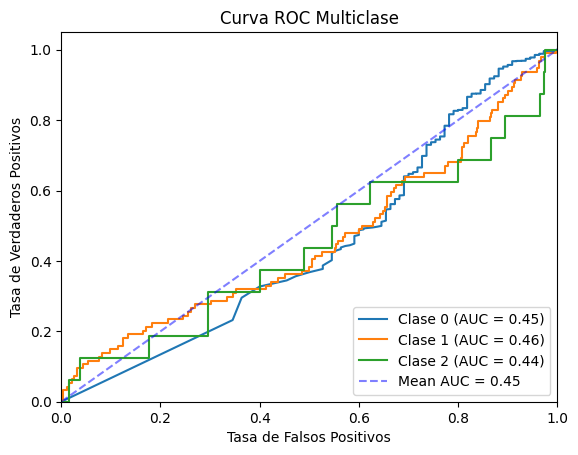

In [30]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Extraer los valores
values = roc_auc.values()
# Calcular la media
mean_auc = sum(values) / len(values)

plt.plot([0, 1], [0, 1], 'b--', label=f"Mean AUC = {mean_auc:.2f}", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()